<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/main/tutorials/W09_RNN/W9_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 9 Part 2
# Introduction to Long-Short-Term-Memory Networks (LSTMs) and their applications

__Instructor__: Lyle Ungar

__Content creators:__ Anushree Hede, Pooja Consul

__Content reviewer:__ Ann-Katrin Reuel

---

In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = '' #@param {type:"string"}
tutorial = 'W9D2'

# start timing
import time
try:t0;
except NameError: t0 = time.time()

In [2]:
# @title Week 9 Slides
from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1TAE6fukLA_Pc6lAZgEOgt-fvg9p2uvEveM-PQVf6D7g/embed?start=false&loop=false&delayms=3000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [3]:
# imports

!pip install --upgrade gensim
!pip install torchtext==0.4.0
!pip install unidecode
!pip install d2l
!pip install matplotlib==3.1.3

import re
import os
import sys
import math
import time
import nltk
import torch
import random
import string
import unidecode
import collections

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from gensim.models import Word2Vec
from nltk.corpus import brown
from sklearn.manifold import TSNE
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors

from IPython.display import Image, YouTubeVideo
from torch.nn import functional as F
from d2l import torch as d2l

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     |████████████████████████████████| 24.1 MB 1.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 53 kB 1.1 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0
     |████████████████████████████████| 235 kB 5.4 MB/s 
     |████████████████████████████████| 82 kB 584 kB/s 
     |████████████████████████████████| 82 kB 53 kB/s 
     |████████████████████████████████| 61 kB 8.0 MB/s 
     |████████████████████████████████| 9.9 MB 21.7 MB/s 
     |████████████████████████████████| 20.1 MB 6.0 MB/s 
     |████████████████████████████████| 11.6 MB 14.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting unin

     |████████████████████████████████| 13.1 MB 1.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


In [4]:
#@title Seeds
seed = 522
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

# plt.rcParams.update(plt.rcParamsDefault)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

In [6]:
#@title Necessary code from Tutorial 1
#@markdown (Running this will take a while)
batch_size = 32 

def tokenize(x):
    x = x.split()
    for i in range(len(x)):
        x[i] = x[i].lower().replace('\n', '')
        x[i] = re.sub(r'[^a-z0-9]+', ' ', x[i])
        x[i] = re.sub(r'https?:/\/\S+', ' ', x[i])
        x[i] = x[i].strip()
    return x

def load_dataset(sentence_length = 50):
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True,
                      include_lengths=True, batch_first=True, fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    # If no specific vector embeddings are specified,
    # Torchtext initializes random vector embeddings
    # which would get updated during training through backpropagation.
    TEXT.build_vocab(train_data)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7, random_state = random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                   batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                   repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, valid_iter, test_iter


def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
      #train
      model.train()
      running_loss = 0.
      correct, total = 0, 0 
      steps = 0

      for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        # print(type(text), text.shape)
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        # add micro for coding training loop
        optimizer.zero_grad()
        output = model(text)
 
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        steps += 1
        running_loss += loss.item()

        # get accuracy 
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # if steps % 100 == 0:
        #     print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {100*(predicted == target).sum().item()/len(batch): .2f}%')

      train_loss.append(running_loss/len(train_iter))
      train_acc.append(correct/total)

      print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0 

      with torch.no_grad():
        for idx, batch in enumerate(valid_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(text)
    
            loss = criterion(output, target)
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(valid_iter))
      validation_acc.append(correct/total)

      print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}%')
  
    return train_loss, train_acc, validation_loss, validation_acc

def test(model,  device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        outputs = model(text)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

def plot_train_val(x, train, val, train_label, val_label, title):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.title(title)
  plt.show()

def count_parameters(model):
    parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return parameters

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d, nn.GRU):
        nn.init.xavier_uniform_(m.weight)

def grad_clipping(net, theta):  
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]

    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset()


downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 29.5MB/s]


---
# Section 1: Long-Short-Term-Memory Networks (LSTMs)

Video available at https://youtube.com/watch?v=8vUJMpYRdjk


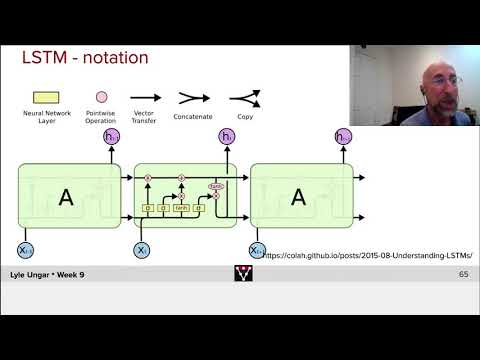

In [7]:
#@title Video: LSTMs
import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="8vUJMpYRdjk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Section 1.1: Architecture

The core idea behind an LSTM is the cell state $C_t$ that runs along all the LSTM units in a layer, and gets updated along the way. These updates are possible through "gates". Gates are made out of a sigmoid neural net layer and a pointwise multiplication operation. 

Each LSTM unit performs the following distinct steps using the input $x_t$, current cell state $C_t$ and previous hidden state $h_{t-1}$:

* Forget Gate: *Should I throw away information from this cell?*
$$f_t = \sigma (W_f . [h_{t-1}, x_t] + b_f)$$ 

* Input Gate:
    * *Should I add new values to this cell?*
$$i_t = \sigma (W_i . [h_{t-1}, x_t] + b_i)$$
    * *What new candidate values should I store?*
$$\tilde{C}_t = tanh (W_C . [h_{t-1}, x_t] + b_C)$$ 

* Update cell state: *Forget things from the past and add new things from the candidates*
$$C_t = (f_t * C_{t-1}) + (i_t * \tilde{C}_t)$$ 

* Output Gate: 
    * *What information should I output?*
$$o_t = \sigma (W_o . [h_{t-1}, x_t] + b_o)$$ 
    * *How much of the cell state should I store in the hidden state?*
$$h_t = o_t * tanh(C_t)$$ 

The architecture can be summarized by the diagram below:
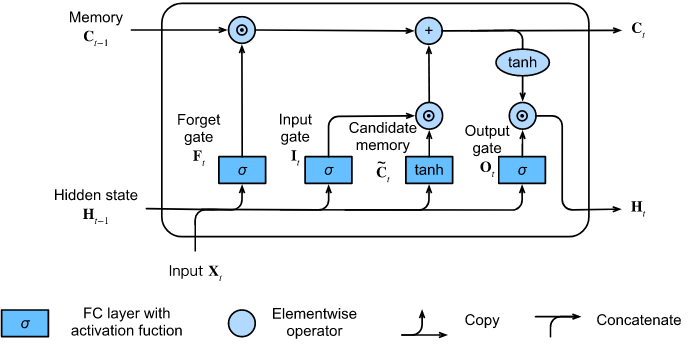

## Quiz Question 1

Since the candidate memory cell ensures that the value range is between  −1  and  1  by using the  $tanh$  function, why does the hidden state need to use the  $tanh$  function again to ensure that the output value range is between  −1  and  1 ?

In [2]:
lstm_range = 'x' #@param {type: "string"}

**to_remove**

The two inputs to the update operation of $C_t$ can have the maximum value of $1$. Hence, the sum of these inputs could result in a value $>1$; which is undesirable. Thus, before $C_t$ is passed to the output gate, it is passed through a $tanh$ to ensure that the range of $H_t$ lies between $[-1, 1]$.

### Exercise 1

It is now your turn to build an LSTM network in PyTorch. Feel free to refer to the documentation here: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM . 

* Once again we will use `nn.Embedding`. You are given the `vocab_size` and the `embed_size`.
* Add the [`LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) layers. 
* Define a dropout layer of 0.5. 
* Determine the size of inputs and outputs to the fully-connected layer.
* Pay special attention to the shapes of your inputs and outputs as you write the forward function.



In [9]:
class LSTM(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size):
    super(LSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.n_layers = layers

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("LSTM Init")
    ####################################################################
    self.word_embeddings = ...
    self.dropout = ...
    self.lstm = ...
    self.fc = ...

  def forward(self, input_sentences):
    """Hint: Make sure the shapes of your tensors match the requirement"""
    
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("LSTM Forward")
    ####################################################################

    # Embeddings 
    # `input` shape: (`num_steps`, `batch_size`, `num_hiddens`)
    input = ...
    
    # Initialize a random hidden state and cell state for this sequence
    hidden = (torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device),
            torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device))
    
    # Dropout for regularization
    input = self.dropout(input)
    
    # LSTM 
    output, hidden = ...
    
    # Pick the hidden state (not cell state) and reshape it for the linear layer
    h_n = ...

    # Linear 
    logits = self.fc(h_n)
    return logits

# # Uncomment to run
# sampleLSTM = LSTM(3, 10, 100, 1000, 300)
# print(sampleLSTM)

In [10]:
# Solution - to remove
class LSTM(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size):
    super(LSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.n_layers = layers

    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(0.5)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=self.n_layers)
    self.fc = nn.Linear(self.n_layers*self.hidden_size, output_size)

  def forward(self, input_sentences):
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    hidden = (torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device),
            torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device))
    input = self.dropout(input)
    output, hidden = self.lstm(input, hidden)
    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)
    logits = self.fc(h_n)
    return logits

The cell below will take 1-2 minutes to run. 

Epoch: 1,  Training Loss: 0.6943, Training Accuracy:  50.36%
Validation Loss: 0.6929, Validation Accuracy:  50.91%
Epoch: 2,  Training Loss: 0.6927, Training Accuracy:  51.46%
Validation Loss: 0.6924, Validation Accuracy:  51.47%
Epoch: 3,  Training Loss: 0.6913, Training Accuracy:  52.60%
Validation Loss: 0.6919, Validation Accuracy:  51.77%
Epoch: 4,  Training Loss: 0.6903, Training Accuracy:  53.07%
Validation Loss: 0.6911, Validation Accuracy:  52.84%
Epoch: 5,  Training Loss: 0.6873, Training Accuracy:  54.95%
Validation Loss: 0.6785, Validation Accuracy:  57.88%
Epoch: 6,  Training Loss: 0.6715, Training Accuracy:  58.94%
Validation Loss: 0.6625, Validation Accuracy:  61.11%
Epoch: 7,  Training Loss: 0.6598, Training Accuracy:  60.30%
Validation Loss: 0.6468, Validation Accuracy:  63.11%
Epoch: 8,  Training Loss: 0.6441, Training Accuracy:  63.49%
Validation Loss: 0.6320, Validation Accuracy:  65.21%
Epoch: 9,  Training Loss: 0.6324, Training Accuracy:  64.61%
Validation Loss: 0.

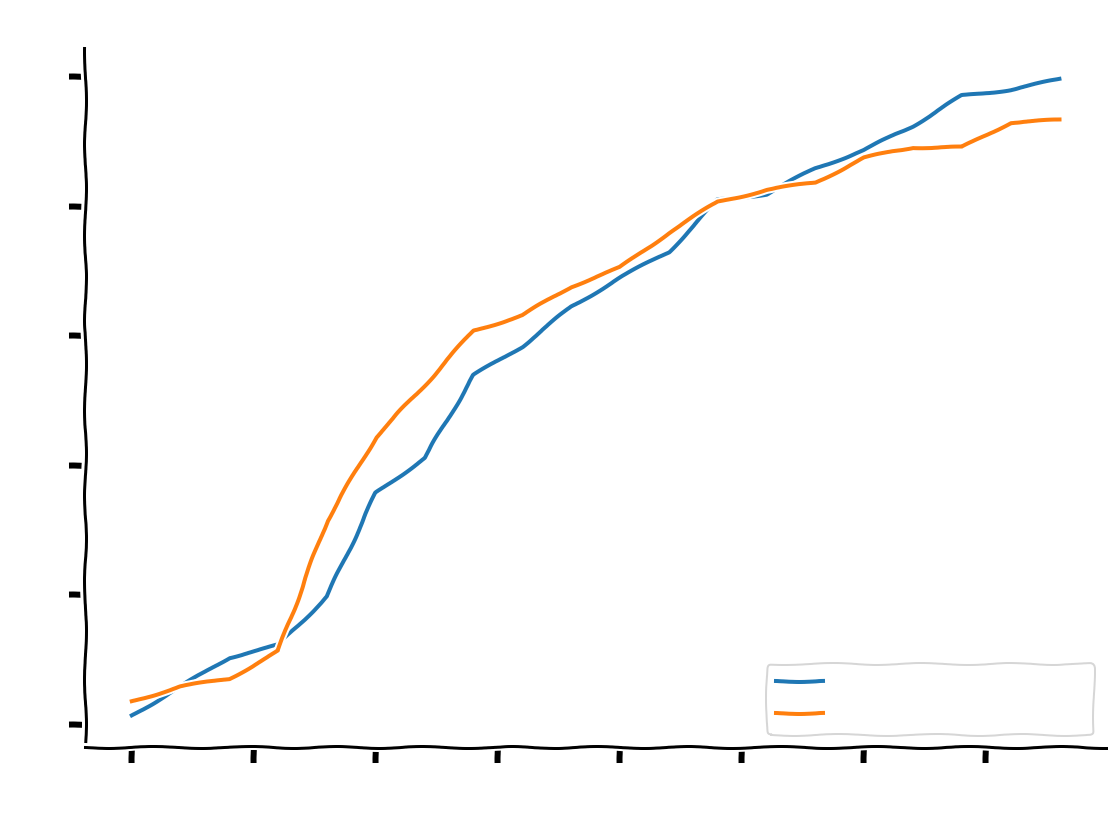

In [11]:
# Hyperparameters
learning_rate = 0.0003
output_size = 2
hidden_size = 16
embedding_length = 100
epochs = 20
layers = 2

# Model, training, testing
lstm_model = LSTM(layers, output_size, hidden_size, vocab_size, embedding_length)
lstm_model.to(device)
lstm_train_loss, lstm_train_acc, lstm_validation_loss, lstm_validation_acc = train(lstm_model, device, train_iter, valid_iter, epochs, learning_rate)
test_accuracy = test(lstm_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%\n')

# Plotting accuracy curve
with plt.xkcd():
    plot_train_val(np.arange(0,epochs), lstm_train_acc, lstm_validation_acc,
                   'training_accuracy', 'validation_accuracy', 'LSTM on IMDB text classification')

## Section 1.2: Gated Recurrent Units (GRU)



The GRU architecture looks very similar to the LSTM, and is often used as an alternative to the traditional LSTM. It also contains some variations that reduce it's complexity. For example, it combines the forget and input gates into a single “update gate”; it contains a "hidden state" but not a "cell state". In the next section we will be using GRUs as the choice of recurrent unit in our models, but you can always swap out the GRU for an LSTM later on (make sure that you take care of input and output dimensions in this case). Here is a description of the parts of the GRU:

* Reset Gate: *How much of the previous hidden state should I remember?*
$$r_t = \sigma (W_r . [h_{t-1}, x_t])$$

* Update Gate: 
    * *How much of the new state is just a different from the old state?*
$$z_t = \sigma (W_z . [h_{t-1}, x_t])$$
    * *What new candidate values should I store?*
$$\tilde{h}_t = tanh (W . [r_t * h_{t-1}, x_t ])$$

* Update hidden state: *Deciding how much of the old hidden state to keep and discard*
$$h_t = ((1-z_t)*h_{t-1} ) + (z_t * \tilde{h}_t) $$


Here is what the architecture looks like:

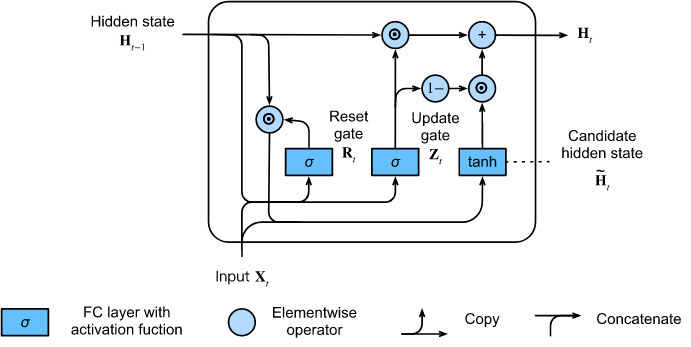

## Section 1.3: biLSTMs


Video available at https://youtube.com/watch?v=7oYePBOq4ec


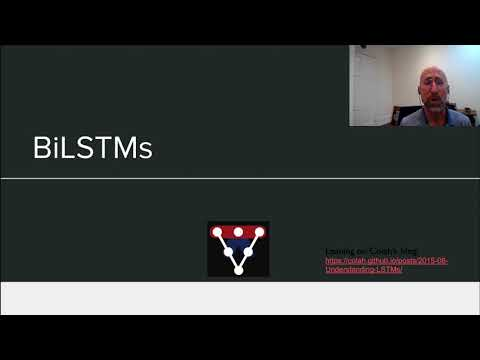

In [12]:
#@title Video: biLSTMs
try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="7oYePBOq4ec", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

#### Exercise 2

Let's apply the knowledge to write a bi-LSTM using PyTorch.

* Use an Embedding layer
* Dropout of 0.5
* Add 2 LSTM layers
* Linear layer 

In [13]:
# Exercise
class biLSTM(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size):
    super(biLSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size

    ####################################################################
    # Fill in missing code below (...)
    raise NotImplementedError("biLSTM")
    ####################################################################
    self.word_embeddings = ...
    self.dropout = ...
    self.bilstm = ...
    self.fc = ...

  def forward(self, input_sentences):
    
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    hidden = (torch.randn(4, input.shape[1], self.hidden_size).to(device),
            torch.randn(4, input.shape[1], self.hidden_size).to(device))
    input = self.dropout(input)
    
    output, hidden = self.bilstm(input, hidden)

    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)
    logits = self.fc(h_n)
    return logits

# # Uncomment to run
# sampleBiLSTM = biLSTM(10, 100, 1000, 300)
# print(sampleBiLSTM)

In [14]:
# solution to_remove
class biLSTM(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size):
    super(biLSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size

    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(0.5)
    self.bilstm = nn.LSTM(embed_size, hidden_size, num_layers=2, bidirectional=True)
    self.fc = nn.Linear(4*hidden_size, output_size)

  def forward(self, input_sentences):

    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    hidden = (torch.randn(4, input.shape[1], self.hidden_size).to(device),
            torch.randn(4, input.shape[1], self.hidden_size).to(device))
    input = self.dropout(input)
    
    output, hidden = self.bilstm(input, hidden)

    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)
    logits = self.fc(h_n)
    return logits

The cell below will take 1-2 minutes to run. 

Epoch: 1,  Training Loss: 0.6943, Training Accuracy:  51.22%
Validation Loss: 0.6929, Validation Accuracy:  51.80%
Epoch: 2,  Training Loss: 0.6926, Training Accuracy:  51.46%
Validation Loss: 0.6902, Validation Accuracy:  53.53%
Epoch: 3,  Training Loss: 0.6900, Training Accuracy:  52.86%
Validation Loss: 0.6858, Validation Accuracy:  55.53%
Epoch: 4,  Training Loss: 0.6768, Training Accuracy:  57.32%
Validation Loss: 0.6591, Validation Accuracy:  61.17%
Epoch: 5,  Training Loss: 0.6540, Training Accuracy:  61.63%
Validation Loss: 0.6343, Validation Accuracy:  64.35%
Epoch: 6,  Training Loss: 0.6336, Training Accuracy:  64.45%
Validation Loss: 0.6290, Validation Accuracy:  64.48%
Epoch: 7,  Training Loss: 0.6183, Training Accuracy:  65.82%
Validation Loss: 0.5996, Validation Accuracy:  67.99%
Epoch: 8,  Training Loss: 0.6020, Training Accuracy:  67.50%
Validation Loss: 0.5853, Validation Accuracy:  69.69%
Epoch: 9,  Training Loss: 0.5839, Training Accuracy:  68.93%
Validation Loss: 0.

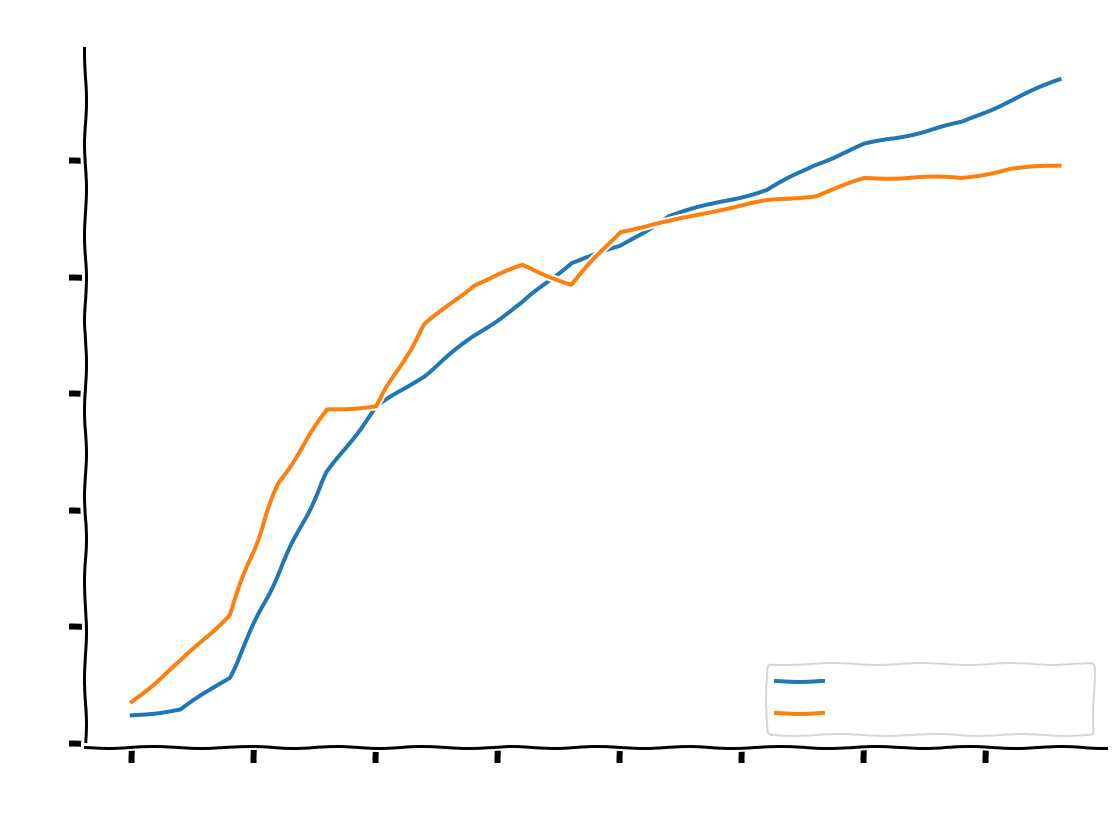

In [15]:
# Hyperparameters
learning_rate = 0.0003
batch_size = 32
output_size = 2
hidden_size = 16
embedding_length = 100
epochs = 20

# Model, training and testing 
biLSTM_model = biLSTM(output_size, hidden_size, vocab_size, embedding_length)
biLSTM_model.to(device)
biLSTM_train_loss, biLSTM_train_acc, biLSTM_validation_loss, biLSTM_validation_acc = train(biLSTM_model, device, train_iter, valid_iter, epochs, learning_rate)
test_accuracy = test(biLSTM_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%\n')

# Plot accuracy curve
with plt.xkcd():
    plot_train_val(np.arange(0,epochs), biLSTM_train_acc, biLSTM_validation_acc,
                   'training_accuracy', 'validation_accuracy', 'biLSTM on IMDB text classification')

---
# Section 2: Applications of RNNs in  NLP

### **Important!** 

In this section, you will use your knowledge of recurrent neural networks and build some interesting NLP applications! For the remainder of the tutorial we will be switching from word-level models to character-level models; which means the text will be tokenized at the character level. We do this in the interest of simplifying our task by limiting our vocabulary (which is now a set of characters instead of words).   


## Section 2.1: Text Generation and Language Modelling


Video available at https://youtube.com/watch?v=pVZ65jRalAU


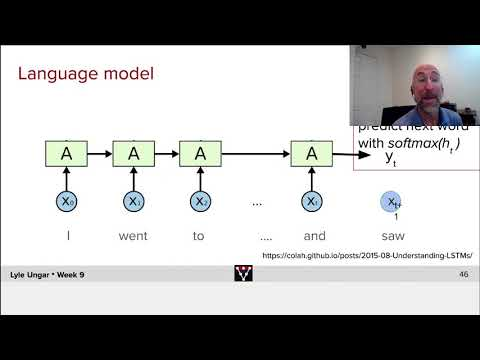

In [16]:
#@title Video: RNN applications and Language Models
try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="pVZ65jRalAU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video



Sources: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html;  
https://d2l.ai/chapter_recurrent-neural-networks/rnn.html#rnn-based-character-level-language-models
  
The first application we will discuss in this section is that of text generation using neural language models. In linguistic theory, a language model is a probability distribution over sequences of words. The task for the model is posed as follows: given a history or context of words, can you predict the next word in the sequence? 

Recurrent neural networks are a natural choice for this task, since they have the ability to capture information from past observations through the hidden state. Andrej Karpathy's [blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is an excellent read for developing intuition for this task. For this exercise, you will train a character-level text generation model, give it an initial "start" string, and watch how it generates characters! 

At any given time step, the model takes one character and a hidden state as input. We convert the output of the model to a probability distribution over the possible characters, and pick a character from this distribution as the next prediction. This "generated" character is then passed to the model as the input in the next time step. This process is repeated for a fixed number of time steps.  (In real generation, these is often a special "stop character" that determines when to stop generation.   

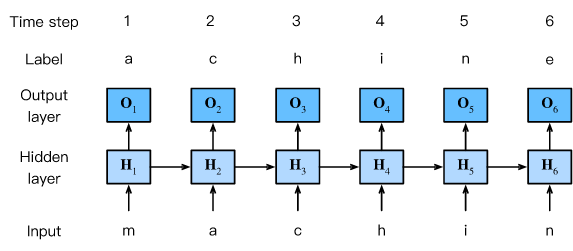

(Language models are generally evaluated using a metric known as [perplexity](https://https://towardsdatascience.com/perplexity-intuition-and-derivation-105dd481c8f3), which is 2 to the entropy of the probability distribution of the language model, measured in bits.)



In [17]:
#@markdown ### Preparing the input (run me)

! wget http://www.gutenberg.org/files/1522/1522-0.txt

# Read the input training file - Julius Caesar 
file = unidecode.unidecode(open('1522-0.txt').read()).lower() 
file = re.sub(r'[^a-z]+', ' ', file)
file_len = len(file)
print('file_len =', file_len)

# Print a random chunk from the training data 
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

chunk_len = 100
print(random_chunk(chunk_len))

# Get a random chunk from the traning data, 
# Convert its first n-1 chars into input char tensor
# Convert its last n-1 chars into target char tensor
def random_training_set():    
    chunk = random_chunk(chunk_len)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Get all printable characters for generation
# all_characters = string.printable
all_characters = string.ascii_lowercase
all_characters += ' '
n_characters = len(all_characters)

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

--2022-03-13 17:00:10--  http://www.gutenberg.org/files/1522/1522-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/1522/1522-0.txt [following]
--2022-03-13 17:00:10--  https://www.gutenberg.org/files/1522/1522-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142176 (139K) [text/plain]
Saving to: ‘1522-0.txt’

1522-0.txt          100%[===================>] 138.84K  --.-KB/s    in 0.1s    

2022-03-13 17:00:10 (1.40 MB/s) - ‘1522-0.txt’ saved [142176/142176]

file_len = 127899
ade him follow so indeed he did the torrent roar d and we did buffet it with lusty sinews throwing it


In [18]:
v = 0
o = 0
s = 0
for i, c in enumerate(file):
    if c == 'i':
        if file[i+1] == 'a' or file[i+1] == 'e' or file[i+1] == 'i' or file[i+1] == 'o' or file[i+1] == 'u':
            v += 1
        elif file[i+1] == ' ':
            s += 1
        else:
            o += 1 

print(v, o, s)

1240 5324 583


### Network

In [19]:
class GenerationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GenerationRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input, hidden)
        output = self.decoder(hidden.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

### Generate

#### Exercise 3

Now that you know what the network looks like, write the function below that:
* Takes in a `prime_str` and builds up a hidden state 
* Uses the built up hidden state to iteratively generate `predict_len` number of characters from the model
* To predict the next state, softmax the output from the model and pick the character with the maximum probability 

In [20]:
def evaluate(net, prime_str, predict_len):
    hidden = net.init_hidden()
    predicted = prime_str

    # "Building up" the hidden state
    for p in range(len(prime_str) - 1):
        inp = char_tensor(prime_str[p])
        _, hidden = net(inp, hidden)
    
    # Tensorize of the last character
    inp = char_tensor(prime_str[-1])
    
    # For every index to predict
    for p in range(predict_len):
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Generation")
        ####################################################################

        # Pass the inputs to the model
        output, hidden = ...
        
        # Pick the character with the highest probability 
        top_i = ...

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# # Uncomment to run
# sampleDecoder = GenerationRNN(27, 100, 27, 1)
# text = evaluate(sampleDecoder, 'hi', 10)
# if text.startswith('hi') and len(text) == 12:
#     print('Success!')
# else:
#     print('Need to change.')

In [21]:
# Solution - to remove
def evaluate(net, prime_str, predict_len):
    hidden = net.init_hidden()
    predicted = prime_str

    # "Building up" the hidden state
    for p in range(len(prime_str) - 1):
        inp = char_tensor(prime_str[p])
        _, hidden = net(inp, hidden)
    
    # Tensorize of the last character
    inp = char_tensor(prime_str[-1])
    
    # For every index to predict
    for p in range(predict_len):
        
        # Pass the inputs to the model
        output, hidden = net(inp, hidden)
        
        # Pick the character with the highest probability 
        top_i = torch.argmax(torch.softmax(output, dim=1))

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

Epoch 500 --------------------
	the the the the the the the the the the the the the 
Epoch 1000 --------------------
	the the the the the the the the the the the the the 
Epoch 1500 --------------------
	ther the the the the the the the the the the the the
Epoch 2000 --------------------
	ther the caesar the caesar the caesar the caesar the
Epoch 2500 --------------------
	ther the so the so the so the so the so the so the s
Epoch 3000 --------------------
	ther the so the so the so the so the so the so the s




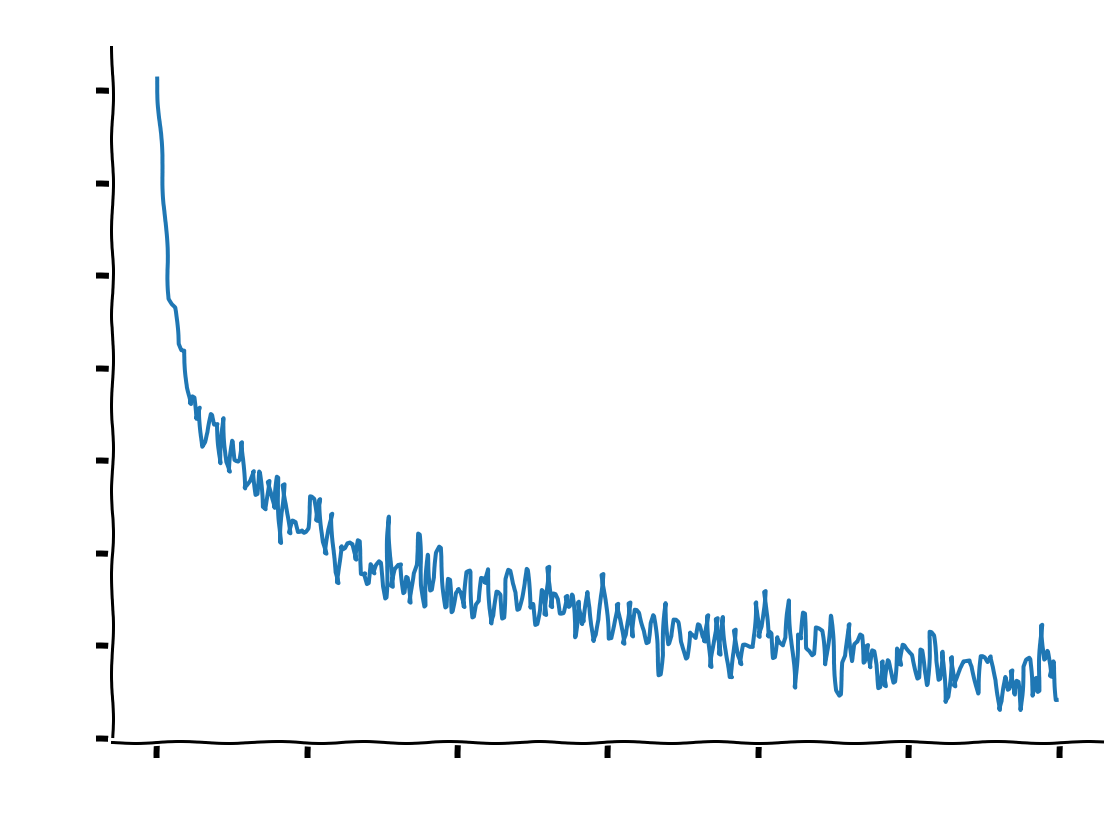

In [22]:
#@title Train

# Single training step
def train(inp, target):
    # Initialize hidden state, zero the gradients of decoder 
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    # For each character in our chunk (except last), compute the hidden and ouput
    # Using each output, compute the loss with the corresponding target 
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))
    
    # Backpropagate, clip gradient and optimize
    loss.backward()
    grad_clipping(decoder, 1)
    decoder_optimizer.step()

    # Return average loss
    return loss.data.item() / chunk_len

n_epochs = 3000
print_every = 500
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.0005

# Create model, optimizer and loss function
decoder = GenerationRNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

# For every epoch
for epoch in range(1, n_epochs + 1):
    # Get a random (input, target) pair from training set and perform one training iteration    
    loss = train(*random_training_set())       
    loss_avg += loss
    
    if epoch % print_every == 0:
        text = evaluate(decoder, 'th', 50)
        print('Epoch '+ str(epoch) + ' --------------------\n\t' + text)
        
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print('\n')
with plt.xkcd():
    plt.figure()
    plt.plot(all_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss for text generation')

## Quiz Question 2

What do you observe about the output of the text generation model? Why do you think this is happening?

In [3]:
generation_output = 'x' #@param {type: "string"}

**Solution**

We notice that the same set of characters are generated repeatedly, the model always picks the best choice, and doesn't explore or sample across different options of characters at each step.  

### Improve Generation

#### Exercise 4

Choosing the character with the highest probability at each time step did not allow us to fully explore the variability in language. For this, we must let the model "explore" other character choices as well. One of the ways to do this is to sample from a probability distribution. 

Implement the function to generate text again, but this time we cast the output to a probability distribution. Your task is to sample a character from this distribution. Use this function: https://pytorch.org/docs/stable/generated/torch.multinomial.html 

In [24]:
def evaluateMultinomial(net, prime_str, predict_len, temperature=0.8):
    hidden = net.init_hidden()
    predicted = prime_str

    # "Building up" the hidden state
    for p in range(len(prime_str) - 1):
        inp = char_tensor(prime_str[p])
        _, hidden = net(inp, hidden)
    
    # Tensorize of the last character
    inp = char_tensor(prime_str[-1])
    
    # For every index to predict
    for p in range(predict_len):

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Generation Improve")
        ####################################################################

        # Pass the character + previous hidden state to the model
        output, hidden = ...
        
        # Sample from the network as a multinomial distribution
        output = output.data.view(-1).div(temperature).exp()
        top_i = ...
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# # Uncomment to run
# sampleDecoder = GenerationRNN(27, 100, 27, 1)
# text = evaluateMultinomial(sampleDecoder, 'hi', 10)
# if text.startswith('hi') and len(text) == 12:
#     print('Success!')
# else:
#     print('Need to change.')

In [25]:
# Solution - to remove
def evaluateMultinomial(net, prime_str, predict_len, temperature=0.8):
    hidden = net.init_hidden()
    predicted = prime_str

    # "Building up" the hidden state
    for p in range(len(prime_str) - 1):
        inp = char_tensor(prime_str[p])
        _, hidden = net(inp, hidden)
    
    # Tensorize of the last character
    inp = char_tensor(prime_str[-1])
    
    # For every index to predict
    for p in range(predict_len):

        # Pass the character + previous hidden state to the model
        output, hidden = net(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

Epoch 500 --------------------
	the are you lof i ure lorllt to wrincde serst is al 
Epoch 1000 --------------------
	the sand and averan the ax strarus hach frome you is
Epoch 1500 --------------------
	th sus come lorchre i smat wich dake the i his but h
Epoch 2000 --------------------
	thing a my flare the the stavin and the the the ploj
Epoch 2500 --------------------
	ther me men abut not form betent and lection the man
Epoch 3000 --------------------
	the rown thus mark i with comp a what exefurster com


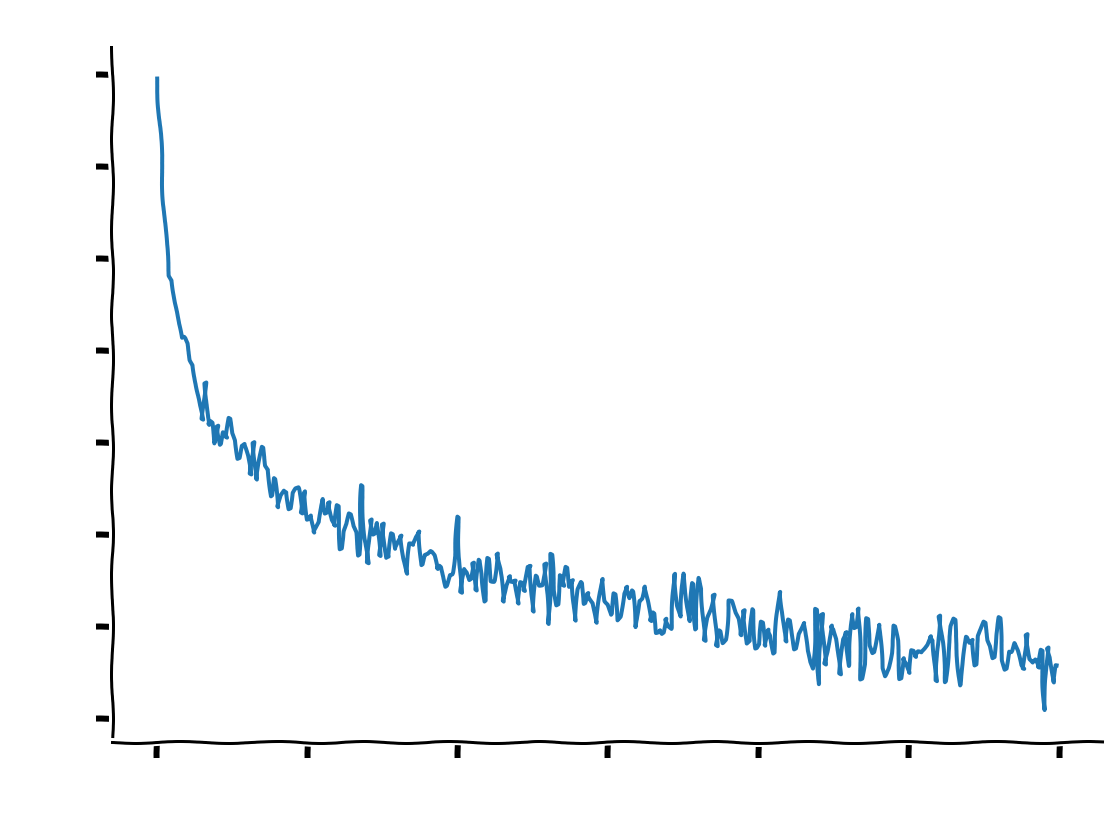

In [26]:
#@title Re-Train
# Single training step
def train(inp, target):
    # Initialize hidden state, zero the gradients of decoder 
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    # For each character in our chunk (except last), compute the hidden and ouput
    # Using each output, compute the loss with the corresponding target 
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))
    
    # Backpropagate, clip gradient and optimize
    loss.backward()
    grad_clipping(decoder, 1)
    decoder_optimizer.step()

    # Return average loss
    return loss.data.item() / chunk_len

n_epochs = 3000
print_every = 500
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.0005

# Create model, optimizer and loss function
decoder = GenerationRNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

# For every epoch
for epoch in range(1, n_epochs + 1):
    # Get a random (input, target) pair from training set and perform one training iteration    
    loss = train(*random_training_set())       
    loss_avg += loss
    
    if epoch % print_every == 0:
        text = evaluateMultinomial(decoder, 'th', 50)
        print('Epoch '+ str(epoch) + ' --------------------\n\t' + text)

        
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

with plt.xkcd():
    plt.figure()
    plt.plot(all_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss for text generation')

## Quiz Question 3

Is there an improvement in the quality of the generated text? Can you infer what the original text used for training could be? 

In [4]:
generation_quality = 'x' #@param {type: "string"}

**Solution**  
Yes, the multinomial distribution over the model output does a better job at sampling over characters than simply choosing the best one at each step.   
The original text was Julius Caesar, Shakespeare.         

## Section 2.2: Sequence Tagging



Video available at https://youtube.com/watch?v=OYhW9HndZkA


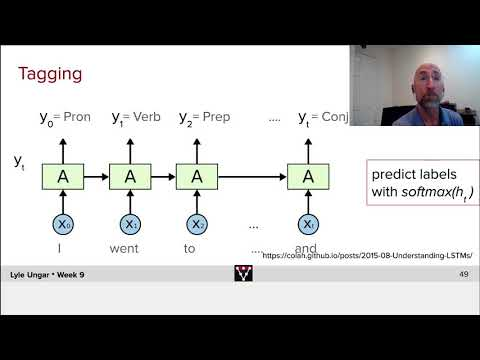

In [28]:
#@title Video: Tagging
try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="OYhW9HndZkA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Sequence tagging is a task in machine learning whose goal is to assign a label (or category) to each unit of a sequence processed in a model. In natural language processing, parts-of-speech tagging and named entity recognition are some popular tagging tasks. 

Formally, we study tagging as a different task from language modelling or text generation, but there are similarities between them. Instead of choosing the next best  character from the output model, we pass the hidden state of each recurrent unit from the model to a fully connected layer and assign it a label.    

In [29]:
#@title Dataloader
class TaggingDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, raw_data):
        'Initialization'
        self.data = raw_data
        self.vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        inp = char_tensor(self.data[index][:-1])
        target = []
        for c in self.data[index][1:]:
            if c in self.vowels:
                target.append(0)
            elif c == ' ':
                target.append(1)
            else:
                target.append(2)
        target = torch.tensor(target)
        # print(self.data[index][:-1], target)
        return inp, target

# Data loaders
raw_data = []
for i in range(100):
    raw_data.append(random_chunk(chunk_len))
dataset = TaggingDataset(raw_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

### Network

#### Exercise 5

For this exercise, you will train a character-level sequence labelling model on the same dataset as the previous exercise: which takes in a character and a hidden state vector as input, and predicts whether the **next** character in the sequence will be a vowel (V), space (S) or other (O). Much of the code for this task is identical to the code for text generation, so you will be making the most important tweaks in the text generation pipeline that will give you a a tagging pipeline. Note that since we are reducing the prediction space to just three classes, the task becomes much more simple.

Structurally, the tagging model looks similar to the text generation one, except the Linear layer must map to the the number of tags or labels defined for your task. Functionally, the hidden state (instead of the output) must be mapped to the Linear layer to perform the classification of the required unit. Use a GRU for the recurrent unit. 

In [30]:
class TaggingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(TaggingRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Tagging Init")
        ####################################################################

        self.embedding = ...
        self.gru = ...
        self.linear = ...
    
    def forward(self, input, hidden):
        """ Be sure to check the shapes of the input and hidden states """
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Tagging Forward")
        ####################################################################

        input = ...
        output, hidden = ...
        out = ...
        return out, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

# # Uncomment to run
# sampleTagger = TaggingRNN(20, 100, 10, 2)
# print(sampleTagger)

Sample Output:

```
TaggingRNN(
  (embedding): Embedding(20, 100)
  (gru): GRU(100, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)
```



In [31]:
# Solution - to remove
class TaggingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(TaggingRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, 3)
    
    def forward(self, input, hidden):
        input = self.embedding(input.view(1, -1)) 
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        out = self.linear(hidden)
        return out, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

### Evaluation

Here is a function that performs the Vowel/Space/Other tagging task for each character of the given string. You don't need to code anything, but notice the similarities between it and the evaluation code for the text generation task.  

In [32]:
def evaluate(prime_str, predict_len):
    labels = ['Vowel', 'Space', 'Other']

    hidden = tagger.init_hidden()
    prime_input = char_tensor(prime_str)
    build_up = len(prime_str) - predict_len
    predicted = prime_str[:build_up]

    # Use priming string to "build up" hidden state
    for p in range(build_up):
        _, hidden = tagger(prime_input[p], hidden)

    column_width = len('milan_is_a_nice_place')+2
    
    print('Text'.ljust(column_width) + 'Next Character is ...\n-------------------------')
    
    # For each character remaining to be tagged 
    for p in range(0, predict_len):

        # Get it's input tensor 
        inp = prime_input[build_up + p]
        next_char = prime_str[build_up + p]
        predicted += next_char

        # Pass the input and the previous hidden state to the model
        out, hidden = tagger(inp, hidden)
        
        # Softmax the output and find the best tag
        softmax = torch.softmax(out[0], dim=1, dtype=torch.float)
        i = torch.argmax(softmax)
        label = labels[i]

        text = predicted.replace(' ', '_')
        print(text.ljust(column_width) + label)

### Training process


------ Epoch 5
Text                   Next Character is ...
-------------------------
milan_i                Other
milan_is               Space
milan_is_              Other
milan_is_a             Other
milan_is_a_            Other
milan_is_a_n           Vowel
milan_is_a_ni          Other
milan_is_a_nic         Vowel
milan_is_a_nice        Space
milan_is_a_nice_       Vowel
milan_is_a_nice_p      Other
milan_is_a_nice_pl     Vowel
milan_is_a_nice_pla    Other
milan_is_a_nice_plac   Vowel
milan_is_a_nice_place  Space

------ Epoch 10
Text                   Next Character is ...
-------------------------
milan_i                Other
milan_is               Space
milan_is_              Vowel
milan_is_a             Other
milan_is_a_            Other
milan_is_a_n           Vowel
milan_is_a_ni          Other
milan_is_a_nic         Vowel
milan_is_a_nice        Space
milan_is_a_nice_       Vowel
milan_is_a_nice_p      Vowel
milan_is_a_nice_pl     Vowel
milan_is_a_nice_pla    Other
milan_is_a_ni

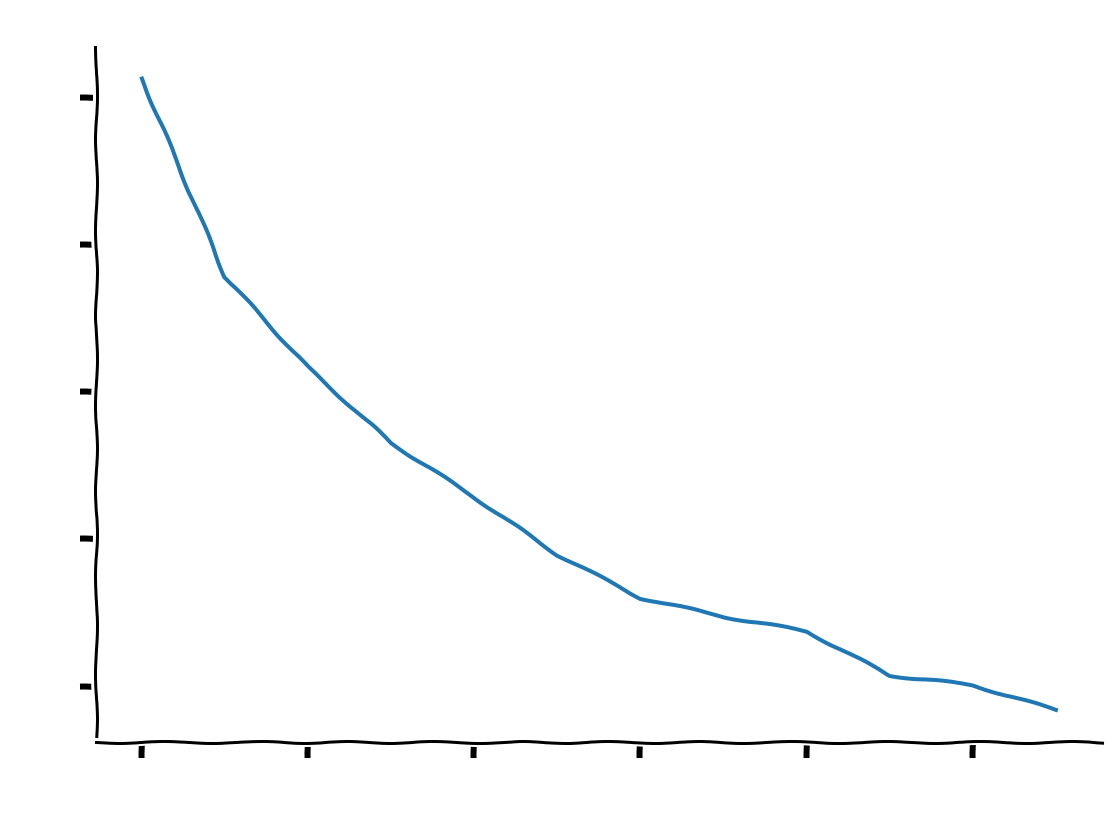

In [33]:
#@title Train
# Single training step
def train(inp, target):
    # Initialize hidden state, zero the gradients of decoder 
    hidden = tagger.init_hidden()
    tagger.zero_grad()
    loss = 0

    # For each character in our chunk (except last), compute the hidden and ouput
    # Using each output, compute the loss with the corresponding target 
    for c in range(chunk_len):
        
        out, hidden = tagger(inp[c], hidden)
        loss += criterion(out[0], target[c].unsqueeze(0))
        
    # Backpropagate and optimize
    loss.backward()
    optimizer.step()

    # Return average loss
    return loss.data.item() / chunk_len

n_epochs = 12
print_every = 5
plot_every = 1
hidden_size = 100
n_layers = 1
lr = 0.005

# Create model, optimizer and loss function
tagger = TaggingRNN(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(tagger.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0


# For every epoch
for epoch in range(1, n_epochs + 1):

    for i, (input, target) in enumerate(dataloader):
        loss = train(input[0], target[0])
        loss_avg += loss

    if epoch % print_every == 0:
        print('\n------ Epoch %d' % epoch)
        evaluate('milan is a nice place', 15)
    
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

with plt.xkcd():
    plt.figure()
    plt.plot(all_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss for sequence labelling')

## Quiz Question 4

Where is the model making mistakes? Why is there a difference between the true next character and the Next Character tag? 

*Hint: Observe the input to the network at each time step in the `evaluate` function*

In [5]:
seq_label_mistakes = 'x' #@param {type: "string"}

## Section 2.3: Sequence to Sequence 



Video available at https://youtube.com/watch?v=DebMnQ7PYg0


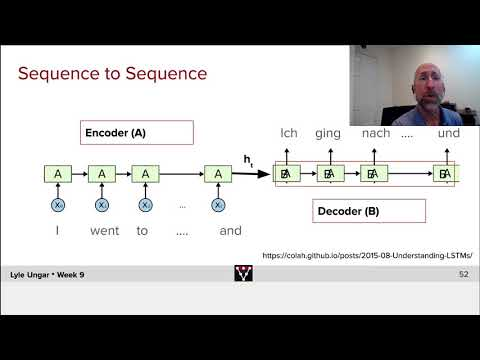

In [36]:
#@title Video: Seq2Seq Modelling
try: t4;
except NameError: t4=time.time()

video = YouTubeVideo(id="DebMnQ7PYg0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Sources: [d2l.ai on encoders](https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html) ; [d2l.ai on seq2seq](https://d2l.ai/chapter_recurrent-modern/seq2seq.html) ; [Jalammar's blog](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/ )

Sequence-to-sequence models take in a sequence of items (words, characters, etc) as input and produces another sequence of items as output. The most 
simple seq2seq models are composed of two parts: the encoder, the context ("state" in the figure) and the decoder. The encoder and decoder usually consist of recurrent units that we've seen before (RNNs, GRUs or LSTMs). A high-level schematic of the architecture is as follows:

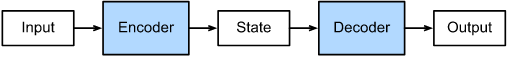

The encoder's recurrent unit processes the input one item at a time. Once the entire sequence is processed, the final hidden state vector produced is known as a context vector. The size of the context vector is defined while setting up the model, and is equal to the number of hidden states used in the encoder RNN. The encoder then passes the context to the decoder. The decoder's recurrent unit uses the context to produce the items for the output sequence one by one.   


One of the most popular applications of seq2seq models is "machine translation": the task of taking in a sentence in one language (the source) and producing its translation in another language (the target); with words in both lanugages being the sequence units. This is a supervised learning task, and requires the dataset to have "parallel sentences"; i.e., each sentence in the source language must be labelled with its translation in the target language. 

[Here is an intuitive visualization for understanding seq2seq models for machine translation from English to French](https://i.imgur.com/HJ6t8up.mp4)

Since the vocabulary of an entire language is very large, training such models to give meaningful performance requires significant time and resources. In this section, we will train a seq2seq model to perform machine translation from English to [Pig-Latin](https://en.wikipedia.org/wiki/Pig_Latin). We will modify the task to perform character-level machine translation, so that vocabulary size does not grow exponentially.   


### Setup

In [37]:
#@title Preprocessing
! wget https://sourceforge.net/projects/wordlist/files/speller/2020.12.07/wordlist-en_US-large-2020.12.07.zip

! unzip wordlist-en_US-large-2020.12.07.zip

def t(str):
    return str[0]+str[1]
def pig_latinize(word):
    lst = ['sh', 'gl', 'ch', 'ph', 'tr', 'br', 'fr', 'bl', 'gr', 'st', 'sl', 'cl', 'pl', 'fl']
    # sentence = input('Type what you would like translated into pig-latin and press ENTER: ')
    # sentence = sentence.split()
    i = word
    if i[0] in ['a', 'e', 'i', 'o', 'u']:
        word = i+'ay'
    elif t(i) in lst:
        word = i[2:]+i[:2]+'ay'
    elif i.isalpha() == False:
        word = i
    else:
        word = i[1:]+i[0]+'ay'
    return word

def read_data():
    # data_folder = 'scowl-2020.12.07/final'
    word_list = []
    # for file_ in os.listdir(data_folder):
    #     if 'american-words' in file_:
    with open('en_US-large.txt') as f:
        word_list.extend(f.readlines())

    clean_wordlist = [unidecode.unidecode(w.strip().lower()) for w in word_list if w.strip().isalpha() and len(w.strip())>2 and len(w.strip())<6]

    data = []
    for word in clean_wordlist:
        data.append(word + ' ' + pig_latinize(word))

    return data

def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    source_char_set = set()
    target_char_set = set()
    for i, line in enumerate(text):
        if num_examples and i > num_examples:
            break
        parts = line.split(' ')
        # parts = line.split('\t')
        if len(parts) == 2:
            src_txt, tgt_txt = parts
            cur_src, cur_tgt = [], []
            for c in src_txt:
                cur_src.append(c)
                source_char_set.add(c)
            for c in tgt_txt:
                cur_tgt.append(c)
                target_char_set.add(c)
            source.append(cur_src)
            target.append(cur_tgt)

    special_tokens = ['<eos>', '<bos>', '<pad>']
    for tok in special_tokens:
        source_char_set.add(tok)
        target_char_set.add(tok)    
    return source, target, sorted(list(source_char_set)), sorted(list(target_char_set)) 

--2022-03-13 17:09:04--  https://sourceforge.net/projects/wordlist/files/speller/2020.12.07/wordlist-en_US-large-2020.12.07.zip
Resolving sourceforge.net (sourceforge.net)... 104.18.10.128, 104.18.11.128
Connecting to sourceforge.net (sourceforge.net)|104.18.10.128|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/wordlist/files/speller/2020.12.07/wordlist-en_US-large-2020.12.07.zip/ [following]
--2022-03-13 17:09:04--  https://sourceforge.net/projects/wordlist/files/speller/2020.12.07/wordlist-en_US-large-2020.12.07.zip/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/wordlist/files/speller/2020.12.07/wordlist-en_US-large-2020.12.07.zip/download [following]
--2022-03-13 17:09:04--  https://sourceforge.net/projects/wordlist/files/speller/2020.12.07/wordlist-en_US-large-2020.12.07.zip/download
Reusing exist

The following cell retrieves about 29,000 random English words and their Pig Latin translations. We then tokenize each word and its translation; in this case, our tokens are characters. We also create vocabularies for the source and target languages; and a two-way mapping for each (index to token and token to index). Finally, we pick the value for `NUM_STEPS` as the size of the largest sequence in either language. This value would mark the maximum size of the sequence accepted by our models.  

In [38]:
data = read_data()

source, target, source_vocab, target_vocab = tokenize_nmt(data)

source_idx2token = dict((i, char) for i, char in enumerate(source_vocab))
target_idx2token = dict((i, char) for i, char in enumerate(target_vocab))
source_vocab = dict((char, i) for i, char in enumerate(source_vocab))
target_vocab = dict((char, i) for i, char in enumerate(target_vocab))

NUM_STEPS = max(max([len(s) for s in source]), max([len(t) for t in target]))

### Padding

The input sequences to our model can vary in length, so it is often convenient to have a consistent length among all inputs to the model (This is not required by recurrent models, but makes it easier to control minibatch size). If our defined maximum sequence length is $M$ and a given input sequence is less than that, then we pad it with zeros (our "special padding symbol:, until its length becomes $M$.      



#### Exercise 6

Implement a function below that performs truncation and padding based on a list of tokens (characters) `line` given to it.  

In [39]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Truncate and Pad")
    ####################################################################
    
    # Truncate
    if ...:
        return ...  
    
    # Pad
    number_of_pad_tokens = ...
    padding_list = ...

    return line + padding_list

# # Uncomment to run
# word = ['e', 't', 'u', 'i', 's']
# input = [source_vocab[c] for c in word]
# print('Input test: ', word)
# o1 = truncate_pad(input, 10, source_vocab['<pad>'])
# x = [source_idx2token[i] for i in o1]
# print(x)
# o1 = truncate_pad(input, 1, source_vocab['<pad>'])
# x = [source_idx2token[i] for i in o1]
# print(x)
# o1 = truncate_pad(input, 5, source_vocab['<pad>'])
# x = [source_idx2token[i] for i in o1]
# print(x)

Sample Output:



```
Input test:  ['e', 't', 'u', 'i', 's']
['e', 't', 'u', 'i', 's', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['e']
['e', 't', 'u', 'i', 's']
```



In [40]:
# Solution - to remove
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    # Truncate
    if len(line) > num_steps:
        return line[:num_steps]

    # Pad
    number_of_pad_tokens = num_steps - len(line)
    padding_list = [padding_token] * number_of_pad_tokens

    return line + padding_list

In [41]:
#@title Dataloaders

def build_array(data, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    complete_data, lengths = [], []
    for lines in data:
        lines = [vocab[l] for l in lines]
        lines.append(vocab['<eos>'])
        array = torch.tensor(truncate_pad(lines, num_steps, vocab['<pad>']))
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(0)
        complete_data.append(array)
        lengths.append(valid_len.item())
    return torch.stack(complete_data), torch.tensor(lengths)

class MTDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, source, target):
        'Initialization'
        source_data, source_lens = build_array(source, source_vocab, NUM_STEPS)        
        target_data, target_lens = build_array(target, target_vocab, NUM_STEPS)
        self.source = source_data
        self.source_len = source_lens
        self.target = target_data
        self.target_len = target_lens

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.source)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.source[index], self.source_len[index], self.target[index], self.target_len[index]

### Encoder and Decoder Architecture


#### Exercise 7

Implement the forward functions for the Encoder and Decoder of the seq2seq model as directed. 

The Encoder model is very similar to what you have seen so far:
* Get the embedding of the input `X`
* Pass `X` through the recurrent unit. You can define your own initial hidden state, or omit it (in which case a tensor of zeros is used). 
* There is no linear layer 

You will notice that the Decoder also contains an embedding layer; something that wasn't mentioned during the initial explanation of the seq2seq model. This is because we want to apply "teacher forcing" to this problem. Teacher forcing is a strategy for training RNNs that uses model output from a prior time step as an input. Specifically, 
* Get the embedding of `X` (which is actually output from the previous time step)
* Concatenate it with the previous hidden state
* To the recurrent unit of the decoder pass this concatenation as "input"; and pass the previous hidden state as "hidden"
* Pass the output of the recurrent unit through the linear layer     




In [42]:
class Encoder(nn.Module):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X):
        """Hint: always make sure your sizes are correct"""
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Encoder Forward")
        ####################################################################
        
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        
        # Embedding layer + reshape
        X = ...

        # Recurrent unit
        
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state


class Decoder(nn.Module):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.gru = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs):
        return enc_outputs[1]

    def forward(self, X, state):
        """Hint: always make sure your sizes are correct"""
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Decoder Forward")
        ####################################################################


        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = ...
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = ...
        
        # Concatenate X and context 
        X_and_context = ...
        
        # Recurrent unit
        output, state = self.rnn(X_and_context, state)
        
        # Linear layer
        output = ...

        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

# # Uncomment to run
# encoder = Encoder(1000, 300, 100, 2, 0.1)
# decoder = Decoder(1000, 300, 100, 2, 0.1)
# print(encoder)
# print(decoder)

In [43]:
# Solution - to remove
class Encoder(nn.Module):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Encoder, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X):
        """Hint: always make sure your sizes are correct"""
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)

        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.gru(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state


class Decoder(nn.Module):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.gru = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.dropout = nn.Dropout(0.25)

    def init_state(self, enc_outputs):
        return enc_outputs[1]

    def forward(self, X, state):
        """Hint: always make sure your sizes are correct"""
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.gru(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [44]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X):
        enc_outputs = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_outputs)
        return self.decoder(dec_X, dec_state)

### Training

In [45]:
#@title Masked Loss Function
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [46]:
#@title Train
def train_seq2seq(net, data_loader, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    
    dataset = MTDataset(source, target)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        # TODO: without d2l?
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in dataloader:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            
            # torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=1)
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)

        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

This cell below, takes about 10 minutes to run. 

loss 0.003, 29860.1 tokens/sec on cuda


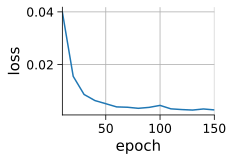

In [47]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1

lr, num_epochs, device = 0.005, 150, torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = MTDataset(source, target)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

encoder = Encoder(
    len(source_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Decoder(
    len(target_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, dataloader, lr, num_epochs, target_vocab, device)

### Evaluation

How do we know that we have obtained a good translation? BLEU (Bilingual Evaluation Understudy) is a metric that was developed specifically for this purpose. If you're curious, you can check out the details of the metric [here](https://d2l.ai/chapter_recurrent-modern/seq2seq.html?highlight=bleu#evaluation-of-predicted-sequences). For now, all you need to know is that a BLEU score lies between 0 and 1; the closer you are to 1; the better your translation is.   

In [1]:
#@title Compute BLEU
def bleu(pred_seq, label_seq, k): 
    """Compute the BLEU."""
    pred_tokens, label_tokens = [c for c in pred_seq], [c for c in label_seq]
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

#### Exercise 8

Implement a function to make a translation of a given word. 

In [49]:
def predict_seq2seq(net, src_sentence, device):
    """Predict for sequence to sequence."""

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Seq2seq prediction")
    ####################################################################

    # Set `net` to eval mode for inference
    net.eval()

    # Get source language tokens 
    src_tokens = [source_vocab[c] for c in src_sentence.lower()] + [source_vocab['<eos>']]
    # Truncate/pad the tokens
    src_tokens = ...
    # Create encoder tensor of the right size 
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    
    # Pass the source sentence tensor to the encoder
    enc_outputs = ...

    # Get the encoder hidden state to pass to the decoder
    dec_state = ...
    
    # Create an input with the <BOS> tag to be passed to the decoder (part of teacher forcing)
    dec_X = torch.unsqueeze(torch.tensor([target_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq = []
    
    # Predict characters for a maximum of the max sequence length
    for _ in range(NUM_STEPS):

        # Pass the decoder input + hidden state to the decoder
        Y, dec_state = ...

        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = ...
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == target_vocab['<eos>']:
            ...
        
        output_seq.append(pred)
    return output_seq

In [50]:
# Solution - to remove
def predict_seq2seq(net, src_sentence):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = [source_vocab[c] for c in src_sentence.lower()] + [source_vocab['<eos>']]
    # enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, NUM_STEPS, source_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X)
    dec_state = net.decoder.init_state(enc_outputs)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor([target_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(NUM_STEPS):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == target_vocab['<eos>']:
            break
        output_seq.append(pred)
    return output_seq

In [51]:
engs = ['middle', 'funny', 'hour', 'igloo', 'vendor', 'moody']
pig_latin = ['iddlemay', 'unnyfay', 'ourhay', 'iglooway', 'endorvay', 'oodymay']

column_width = 18
    
print('English'.ljust(column_width) + 'Pig Latin'.ljust(column_width) + 'Translation'.ljust(column_width) + 'BLEU\n--------------------------------------------------------------')

for eng, pig in zip(engs, pig_latin):
    translation = predict_seq2seq(net, eng)
    translation = ''.join([target_idx2token[i] for i in translation])
    print(eng.ljust(column_width) + pig.ljust(column_width) + translation.ljust(column_width) + '%.3f' % bleu(translation, pig, k=2))
    # print('English: %s; Pig Latin: %s; Translation: %s; BLEU: %.3f' % (eng, pig, translation, bleu(translation, pig, k=2)))

English           Pig Latin         Translation       BLEU
--------------------------------------------------------------
middle            iddlemay          iddela            0.570
funny             unnyfay           unnyrrf           0.711
hour              ourhay            ourray            0.803
igloo             iglooway          iglotay           0.725
vendor            endorvay          endrlay           0.675
moody             oodymay           oodytay           0.837


---
# Wrap up


Video available at https://youtube.com/watch?v=bnnxSA_mDNA


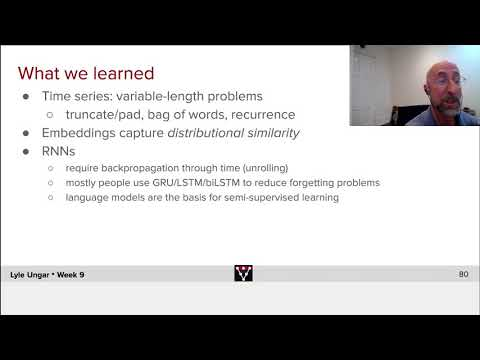

In [55]:
#@title Video: Wrap Up
try: t6;
except NameError: t6=time.time()

video = YouTubeVideo(id="bnnxSA_mDNA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


On your own (for fun; you don't need to hand in anything): take a look at some of the many fun applications on the web. For each one, guess which architecture it is using.

* Speech to text: [alien maths](https://www.alienmaths.com/)

* Image captioning:  [google images](https://blog.google/products/search/get-more-useful-information-captions-google-images/)

In [6]:
#@markdown #Run Cell to Show Airtable Form
#@markdown Confirm your answers and then click "Submit". If you're having any issues, submit your answers here: https://airtable.com/shrXbBgUxF06cyRR3.

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: my_email;
except NameError: my_email = ""
try: lstm_range;
except NameError: lstm_range = ""
try: generation_output;
except NameError: generation_output = ""
try: generation_quality;
except NameError: generation_quality = ""
try: seq_label_mistakes;
except NameError: seq_label_mistakes = ""

times = np.array([t1])-t0

fields = {
        "pennkey": my_pennkey,
        "pod": my_pod, 
        "email": my_email, 
        "lstm_range": lstm_range,
        "generation_output": generation_output,
        "generation_quality": generation_quality,
        "seq_label_mistakes": seq_label_mistakes,
        "cumulative_times": times
}

src = "https://airtable.com/embed/shrXbBgUxF06cyRR3?"

display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shr1TzujOOOY21kFQ">https://airtable.com/shr1TzujOOOY21kFQ</a>

In [ ]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))